In [9]:
#I want to visualize the receival of rm_id over time in a time series plot, to see if there are any trends or seasonality. I want to make a function that
# takes in rm_id as an argument and plots the time series for that specific rm_id by using receivals in /data/kernel/receivals.csv
import pandas as pd
import matplotlib.pyplot as plt

# Load data
receivals = pd.read_csv('../data_cleaned/receivals_cleaned.csv', parse_dates=['date_arrival'])

# I want to check all the unique rm_ids from the last year in receival
print(f"This is receivals cleaned:  \n{receivals[receivals['date_arrival'] >= '2024-01-01']['rm_id'].unique()}")

receival_test = pd.read_csv('../data/kernel/receivals.csv', parse_dates=['date_arrival'])
receival_test['date_arrival'] = pd.to_datetime(receival_test['date_arrival'], utc=True).dt.tz_convert('Etc/GMT-2')

# THIS IS FOR UNCLEANED RECEIVALS
print(f"This is receival uncleaned:  \n{receival_test[receival_test['date_arrival'] >= '2024-01-01']['rm_id'].unique()}")


This is receivals cleaned:  
[3125. 3123. 3282. 3126. 3122. 3265. 3124. 3781. 2134. 3865. 2135. 2142.
 2143. 2124. 2144. 2131. 2132. 2145. 3142. 3901. 3421. 4021. 2133. 2130.
 2741. 2981. 2147. 4044. 3621. 2129. 3883. 2140. 3761. 3362. 3381. 3642.
   nan 2125. 3581. 4161. 2161. 4222. 4081. 3601. 4263. 4302. 3201. 4343.
 3121. 4381. 4401. 4443. 3461. 4441. 3701. 2123. 4462. 4463. 4461. 4481.
 4501.]
This is receival uncleaned:  
[3125. 3123. 3282. 3126. 3122. 3265. 3124. 3781. 2134. 3865. 2135. 2142.
 2143. 2124. 2144. 2131. 2132. 2145. 3142. 3901. 3421. 4021. 2133. 2130.
 2741. 2981. 2147. 4044. 3621. 2129. 3883. 2140. 3761. 3362. 3381. 3642.
   nan 2125. 3581. 4161. 2161. 4222. 4081. 3601. 4263. 4302. 3201. 4343.
 3121. 4381. 4401. 4443. 3461. 4441. 3701. 2123. 4462. 4463. 4461. 4481.
 4501.]


In [10]:
#Functions for plotting

# CUMULATIVE PLOTTING
def plot_rm_id_cumulative(rm_id):
    df = receivals[receivals['rm_id'] == rm_id].copy()
    df = df.set_index('date_arrival').resample('D').sum().reset_index()
    
    # Extract year
    df["year"] = df["date_arrival"].dt.year
    
    # Compute cumulative net_weight per year
    df["cumulative_net_weight"] = df.groupby("year")["net_weight"].cumsum()
    
    # Plot
    plt.figure(figsize=(12, 6))
    for y, yearly_df in df.groupby("year"):
        plt.plot(yearly_df['date_arrival'], yearly_df['cumulative_net_weight'], marker='o', label=str(y))
    
    plt.title(f'Cumulative Time Series of Net Weight for RM_ID: {rm_id}')
    plt.xlabel('Date Arrival')
    plt.ylabel('Cumulative Net Weight')
    plt.legend()
    plt.grid(True)
    plt.show()

# MODULAR CUMULATIVE PLOTTING - can choose year or default to last year
def plot_rm_id_cumulative_year(rm_id, year=None, period_type='year'):
    """
    Plot cumulative net weight for rm_id over a specified period.
    
    Parameters:
    rm_id: The material ID to plot
    year: Specific year to plot (e.g., 2024). If None, uses last year of data
    period_type: 'year' for full year, 'last_year' for rolling 365 days from most recent data
    """
    df = receivals[receivals['rm_id'] == rm_id].copy()
    if df.empty:
        print(f"No data found for rm_id: {rm_id}")
        return
    
    # Filter data based on year parameter
    if year is not None:
        # Specific year
        df_filtered = df[df['date_arrival'].dt.year == year].copy()
        period_label = f"{year}"
    elif period_type == 'last_year':
        # Rolling last year from most recent data
        max_date = df['date_arrival'].max()
        last_year_start = max_date - pd.DateOffset(years=1)
        df_filtered = df[df['date_arrival'] >= last_year_start].copy()
        period_label = f"Last Year (from {last_year_start.strftime('%Y-%m-%d')})"
    else:
        # Default to most recent full calendar year
        max_year = df['date_arrival'].dt.year.max()
        df_filtered = df[df['date_arrival'].dt.year == max_year].copy()
        period_label = f"{max_year}"
    
    if df_filtered.empty:
        print(f"No data found for rm_id: {rm_id} in {period_label}")
        return
    
    # Resample to daily and compute cumulative sum
    df_filtered = df_filtered.set_index('date_arrival').resample('D').sum().reset_index()
    df_filtered["cumulative_net_weight"] = df_filtered["net_weight"].cumsum()
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df_filtered['date_arrival'], df_filtered['cumulative_net_weight'], 
             marker='o', linewidth=2, markersize=4)
    
    plt.title(f'Cumulative Net Weight for RM_ID: {rm_id} ({period_label})')
    plt.xlabel('Date Arrival')
    plt.ylabel('Cumulative Net Weight')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"Total weight in {period_label}: {df_filtered['cumulative_net_weight'].iloc[-1]:,.2f}")
    print(f"Number of deliveries: {(df_filtered['net_weight'] > 0).sum()}")
    print(f"Date range: {df_filtered['date_arrival'].min().strftime('%Y-%m-%d')} to {df_filtered['date_arrival'].max().strftime('%Y-%m-%d')}")

#plot data for specific rm_id
def plot_rm_id_time_series(rm_id):
    df = receivals[receivals['rm_id'] == rm_id]
    df = df.set_index('date_arrival').resample('D').sum().reset_index()
    
    plt.figure(figsize=(12, 6))
    plt.plot(df['date_arrival'], df['net_weight'], marker='o')
    plt.title(f'Time Series of Net Weight for RM_ID: {rm_id}')
    plt.xlabel('Date Arrival')
    plt.ylabel('Net Weight')
    plt.grid(True)
    plt.show()


In [11]:
import pandas as pd

test2024 = pd.read_csv("../validation/test2024.csv")
prediction_mapping = pd.read_csv("../data/prediction_mapping.csv")

merged = test2024.merge(prediction_mapping, on="ID")

print(merged.shape)

(30450, 5)


In [12]:
# print merged
filtered = merged[merged.groupby("rm_id")["predicted_weight"].transform("sum") > 0]
print(filtered.shape)

(6900, 5)


In [13]:
agg_df = filtered.groupby("rm_id", as_index=False).agg({
    "predicted_weight": "max",
}).sort_values("predicted_weight", ascending=False)

In [14]:
print(agg_df)

    rm_id  predicted_weight
35   3781         4569612.6
36   3865         4060750.4
3    2130         2484792.8
21   3125         2119782.0
22   3126         2099090.0
20   3124         1685474.0
26   3282         1661156.0
18   3122         1528324.0
19   3123         1248016.0
9    2140          732508.0
38   3901          600516.0
7    2134          428992.2
25   3265          403298.0
8    2135          345821.0
10   2142          312107.6
34   3761          233354.8
4    2131          166140.8
12   2144          153890.1
37   3883          135548.0
13   2145          133825.3
23   3142          132692.0
16   2741          115682.0
5    2132          114286.2
11   2143          112316.4
29   3421           90549.9
33   3642           83748.0
27   3362           67256.0
14   2147           54670.0
43   4222           51940.0
2    2129           48986.0
39   4021           47250.0
17   2981           35686.0
44   4263           34832.0
41   4081           34090.0
6    2133           

In [15]:
used = set(agg_df["rm_id"])
all_rm_ids = set(receival_test[receival_test['date_arrival'] >= '2024-01-01']['rm_id'].unique())

print(all_rm_ids - used)
print(len(used))


{np.float64(4481.0), np.float64(3461.0), np.float64(2123.0), np.float64(4461.0), np.float64(4462.0), np.float64(4463.0), np.float64(nan), np.float64(3121.0), np.float64(4401.0), np.float64(4501.0), np.float64(3701.0), np.float64(4343.0), np.float64(4441.0), np.float64(4443.0), np.float64(4381.0)}
46


These rm_ids are in 2023 but not in 2024: {np.float64(3841.0), np.float64(3802.0), np.float64(4101.0), np.float64(3941.0), np.float64(2761.0), np.float64(2153.0), np.float64(3821.0), np.float64(3921.0), np.float64(3762.0), np.float64(nan), np.float64(3441.0), np.float64(3161.0), np.float64(3162.0)}
These rm_ids are in 2024 but not in 2023: {np.float64(nan)}
These rm_ids are in 2022 but not in 2023: {np.float64(2561.0), np.float64(2121.0), np.float64(nan), np.float64(2284.0), np.float64(3501.0), np.float64(2521.0), np.float64(2160.0), np.float64(3541.0), np.float64(3481.0), np.float64(3005.0)}
These rm_ids are in 2023 but not in 2022: {np.float64(nan)}
These rm_ids are in 2021 but not in 2022: {np.float64(2402.0), np.float64(nan), np.float64(2601.0), np.float64(3241.0), np.float64(2482.0), np.float64(3222.0), np.float64(3101.0)}
These rm_ids are in 2022 but not in 2021: {np.float64(nan)}


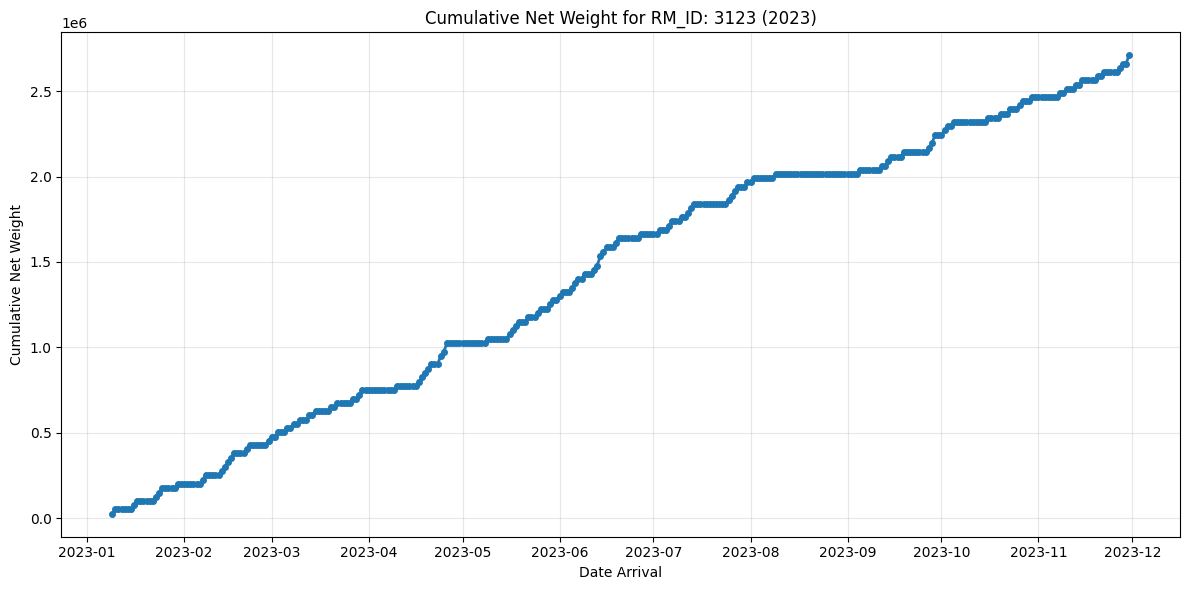

Total weight in 2023: 2,710,020.00
Number of deliveries: 103
Date range: 2023-01-09 to 2023-11-30


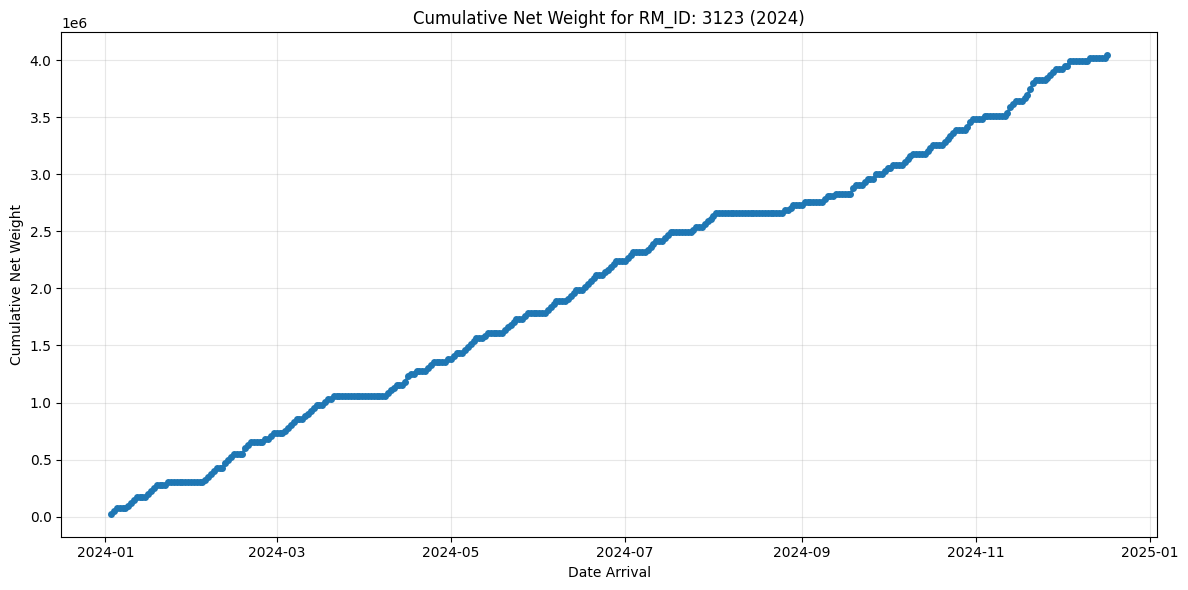

Total weight in 2024: 4,043,100.00
Number of deliveries: 151
Date range: 2024-01-03 to 2024-12-17


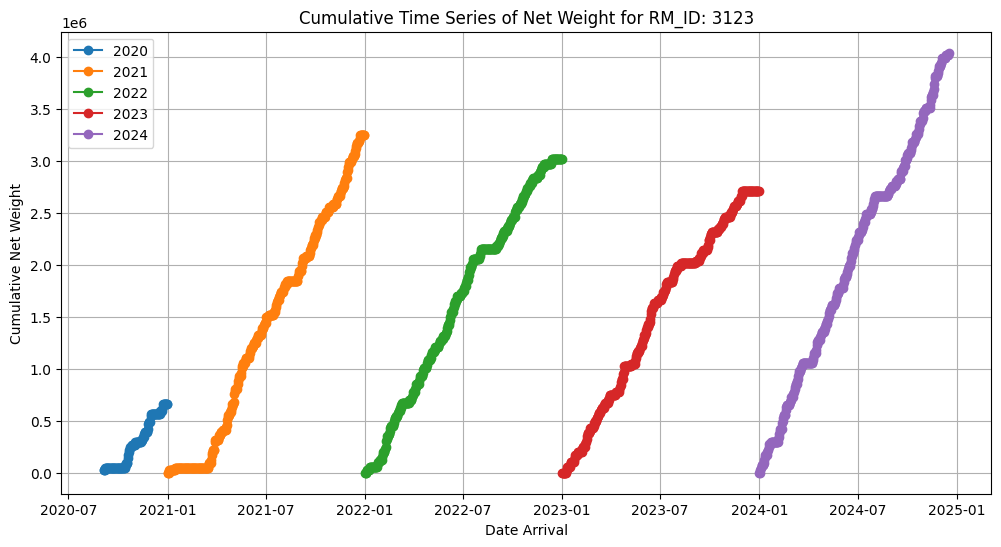

No data found for rm_id: 3362 in 2023


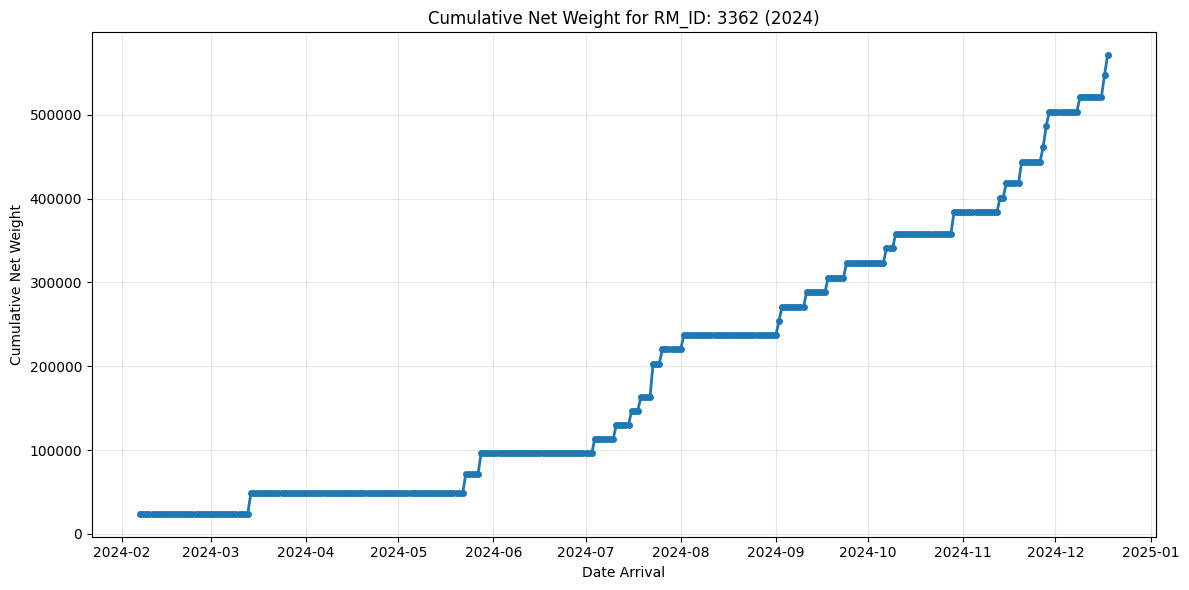

Total weight in 2024: 571,022.00
Number of deliveries: 28
Date range: 2024-02-07 to 2024-12-18


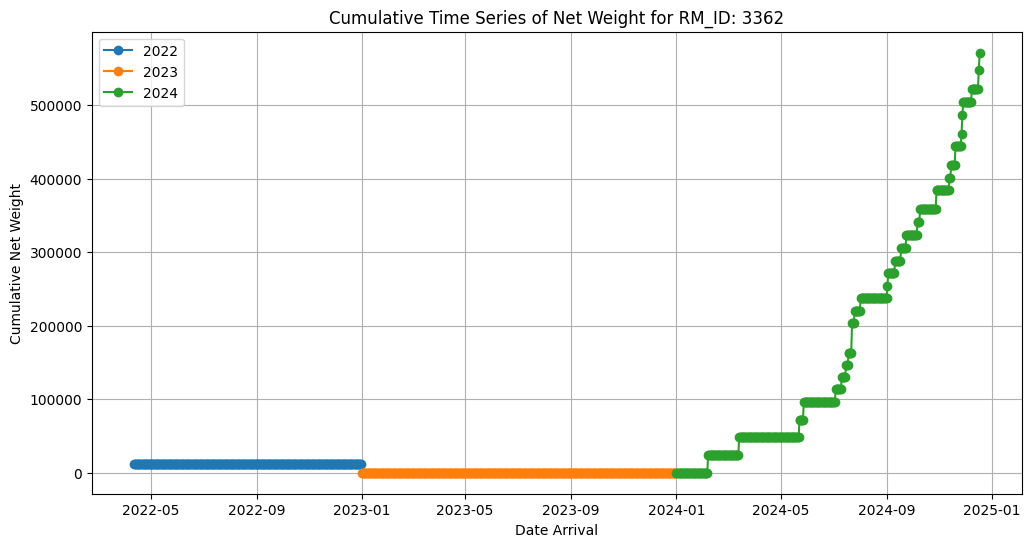

In [16]:
receivals_2021 = receivals[receivals['date_arrival'] >= '2021-01-01']['rm_id'].unique()
receivals_2022 = receivals[receivals['date_arrival'] >= '2022-01-01']['rm_id'].unique()
receivals_2023 = receivals[receivals['date_arrival'] >= '2023-01-01']['rm_id'].unique()
receivals_2024 = receivals[receivals['date_arrival'] >= '2024-01-01']['rm_id'].unique()

print(f"These rm_ids are in 2023 but not in 2024: {set(receivals_2023) - set(receivals_2024)}")
print(f"These rm_ids are in 2024 but not in 2023: {set(receivals_2024) - set(receivals_2023)}")
print(f"These rm_ids are in 2022 but not in 2023: {set(receivals_2022) - set(receivals_2023)}")
print(f"These rm_ids are in 2023 but not in 2022: {set(receivals_2023) - set(receivals_2022)}")
print(f"These rm_ids are in 2021 but not in 2022: {set(receivals_2021) - set(receivals_2022)}")
print(f"These rm_ids are in 2022 but not in 2021: {set(receivals_2022) - set(receivals_2021)}")

#last_10 = agg_df.tail(10)["rm_id"]
#for rm_id in last_10:
#    plot_rm_id_time_series(rm_id)

plot_rm_id_cumulative_year(3123, year=2023)
plot_rm_id_cumulative_year(3123, year=2024)
plot_rm_id_cumulative(3123)

# rm_id 3362 is interesting, because it's the only rm_id
# which is associated with two different product_ids
plot_rm_id_cumulative_year(3362, year=2023)
plot_rm_id_cumulative_year(3362, year=2024)
plot_rm_id_cumulative(3362)

# plot_rm_id_cumulative_year(3781)
# plot_rm_id_cumulative(3781)
# plot_rm_id_cumulative_year(3865)
# plot_rm_id_cumulative(3865)
#plot_rm_id_time_series(2130)
#plot_rm_id_time_series(4501)
#plot_rm_id_time_series(2761)

In [17]:
deprecated = set(receivals_2021) - set(receivals_2024)

In [18]:
for rm_id in deprecated:
    pass # plot_rm_id_time_series(rm_id)

print(f"deprecated rm_ids: {[float(x) for x in deprecated]}")

deprecated rm_ids: [2561.0, 3841.0, 4101.0, 3222.0, nan, 3481.0, 3101.0, 2601.0, 3241.0, 3501.0, 3762.0, 2482.0, 3005.0, 2121.0, 2761.0, 3921.0, 3541.0, 3161.0, 3802.0, 3162.0, 2521.0, 2402.0, 3941.0, 2153.0, 2284.0, 3821.0, 2160.0, 3441.0]


In [19]:
for rm_id in used:
    pass # plot_rm_id_time_series(rm_id)

print(f"active rm_ids: {[float(x) for x in used]}")

active rm_ids: [3201.0, 3601.0, 3865.0, 3362.0, 2981.0, 3621.0, 4263.0, 3883.0, 3761.0, 3122.0, 3123.0, 3124.0, 3125.0, 3126.0, 2741.0, 4021.0, 3381.0, 3642.0, 3901.0, 3265.0, 4161.0, 3781.0, 3142.0, 4044.0, 2125.0, 4302.0, 2124.0, 2129.0, 2130.0, 2131.0, 3282.0, 2132.0, 2134.0, 2135.0, 2133.0, 2140.0, 3421.0, 2142.0, 2143.0, 2144.0, 2145.0, 2147.0, 4081.0, 2161.0, 3581.0, 4222.0]
